In [524]:
import re
import os
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from numpy import genfromtxt

#%% Import libraries
import torch
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset
import os
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR, StepLR, ReduceLROnPlateau

# Load training and test dataframes & TF-IDF matrices

In [525]:
# Load sentences and labels
train = pd.read_csv(r'train_dataframe.csv')
test = pd.read_csv(r'test_dataframe.csv')

In [526]:
train_labels = train["Labels"].tolist()

test_labels = test["Labels"].tolist()

In [527]:
train_tf_idf = pd.read_csv(r'DTTFIDFM_train.csv')
test_tf_idf = pd.read_csv(r'DTTFIDFM_test.csv')

train_tf_idf = train_tf_idf.drop('Unnamed: 0', axis=1)
test_tf_idf = test_tf_idf.drop('Unnamed: 0', axis=1)

In [528]:
train_tf_idf_numpy = train_tf_idf.to_numpy()
test_tf_idf_numpy = test_tf_idf.to_numpy()

In [455]:
# train_tf_idf_numpy

In [529]:
train_tf_idf_numpy.shape,test_tf_idf_numpy.shape

((4929, 16986), (1643, 16986))

# CNN

## Load SVD-matrix:

In [624]:
# Load SVD-matrix from csv-file
V_300 = genfromtxt('V300.csv', delimiter=',')

In [458]:
V_200

array([[-1.01522614e-01,  1.11495275e-01, -1.94767568e-01, ...,
         1.68914466e-02, -1.59969860e-02, -4.14657793e-02],
       [-8.21504456e-02,  5.38646152e-02, -5.83989941e-03, ...,
        -6.59796006e-03, -5.48038621e-03,  3.82854767e-02],
       [-9.73437764e-04,  7.31839751e-04, -1.98419009e-04, ...,
        -4.65777427e-04,  7.10243628e-04,  7.45946970e-04],
       ...,
       [-6.25781132e-04,  4.19897409e-04,  4.62287900e-05, ...,
         1.21027324e-04,  6.06961375e-06,  7.62899044e-04],
       [-5.13986347e-04,  4.40283044e-05,  2.03693542e-04, ...,
        -1.50341156e-04,  7.16554560e-05,  6.35583134e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [532]:
V_200.shape

(16986, 200)

In [533]:
type(V_200)

numpy.ndarray

## Sentence LSA embedding

In [625]:
def sentence_LSA_embedding(TF_IDF_matrix_numpy, V_k):
    liste_LSA_vektorer = []
    for i in range(TF_IDF_matrix_numpy.shape[0]):
        lsa_vector = np.dot(TF_IDF_matrix_numpy[i], V_k)
        liste_LSA_vektorer.append(lsa_vector)
    return np.array(liste_LSA_vektorer)

In [626]:
train_lsa = sentence_LSA_embedding(train_tf_idf_numpy, V_300)
test_lsa = sentence_LSA_embedding(test_tf_idf_numpy, V_300)

## Make tensors

In [693]:
# Convert inputs
train_input_tensor = torch.tensor(train_lsa, dtype=torch.float32)  # Shape: (num_train_sentences, 200)
test_input_tensor = torch.tensor(test_lsa, dtype=torch.float32)    # Shape: (num_test_sentences, 200)

# Convert labels
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # Shape: (num_train_sentences,)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)    # Shape: (num_test_sentences,)

In [694]:
# Reshape the tensors for CNN input (adding the channel dimension)
train_input_tensor = train_input_tensor.unsqueeze(1)  # Shape: (num_train_sentences, 1, 200)
test_input_tensor = test_input_tensor.unsqueeze(1)    # Shape: (num_test_sentences, 1, 200)

In [695]:
train_input_tensor.shape, test_input_tensor.shape

(torch.Size([4929, 1, 300]), torch.Size([1643, 1, 300]))

In [696]:
batch_size = 64
# Create datasets
train_dataset = TensorDataset(train_input_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_input_tensor, test_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # No shuffle for testing

## Build the CNN

In [697]:
num_epochs = 100
learning_rate = 0.0007
weight_decay = 0.0001

In [698]:
#%% Device
# Run on GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [707]:
#%% Neural network
net = torch.nn.Sequential(
    # Block 1
    torch.nn.Conv1d(1, 32, kernel_size=3), # 300 - 3 + 1 = 298
    torch.nn.Dropout(p=0.1),
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(kernel_size=2),

    torch.nn.Flatten(), # 32 * 298 = 9536
    torch.nn.Dropout(p=0.4),
    torch.nn.Linear(32 * 298, 32 * 128), 
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(32 * 128, 2)
).to(device)

In [708]:
#%% Loss and optimizer
# Hvis vi har flere samples
# w0 = total / (2.0 * N0)
# w1 = total / (2.0 * N0)
# loss_function = torch.nn.CrossEntropyLoss(weight=torch.tensor([w0, w1]).to(device))

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [709]:
# %% Load trained network from file
# net.load_state_dict(torch.load('netV5.pt'))

## Train

In [710]:
#%% Train
train_loss = {}
test_loss = {}
train_accuracy = {}
test_accuracy = {}
step = 0

test_labels_dronning = {}
test_labels_statsminister = {}

scheduler = StepLR(optimizer, 5, 0.9)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        net.train()

        # Put data on GPU 
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Compute loss and take gradient step
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, dim=1)

        running_loss += loss.item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Print accuracy for epoch            
    epoch_loss = running_loss / len(train_loader)

    train_loss[epoch] = epoch_loss

    epoch_accuracy = 100 * correct / total

    train_accuracy[epoch] = epoch_accuracy

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_accuracy:.2f}%")

    # Evaluate the model
    net.eval()
    correct = 0
    total = 0
    running_loss_test = 0.0

    dronning_correct = 0
    dronning_total = 0
    statsminister_correct = 0
    statsminister_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Put data on GPU 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = net(inputs)
            
            predicted = torch.argmax(outputs, dim=1)

            loss = loss_function(outputs, labels)
            
            running_loss_test += loss.item()

            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Label-wise counting
            dronning_correct += (((predicted == 0) & (labels == 0))).sum().item()
            dronning_total += (labels == 0).sum().item()

            statsminister_correct += (((predicted == 1) & (labels == 1))).sum().item()
            statsminister_total += (labels == 1).sum().item()

        epoch_loss_test = running_loss_test / len(test_loader)
        test_loss[epoch] = epoch_loss_test

    test_accuracy_score = 100 * correct / total
    
    dronning_acc = 100.0 * dronning_correct / dronning_total
    statsminister_acc = 100.0 * statsminister_correct / statsminister_total

    # Store label-wise accuracy for testing
    test_labels_dronning[epoch] = dronning_acc
    test_labels_statsminister[epoch] = statsminister_acc

    test_accuracy[epoch] = test_accuracy_score

    print(f"Test loss: {epoch_loss:.4f}, Test accuracy: {test_accuracy_score:.2f}%")
    print(f"Dronning (0) accuracy: {dronning_acc:.2f}% - Statsminister (1) accuracy: {statsminister_acc:.2f}%")
    print()

    scheduler.step(epoch_loss_test)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x4768 and 9536x4096)

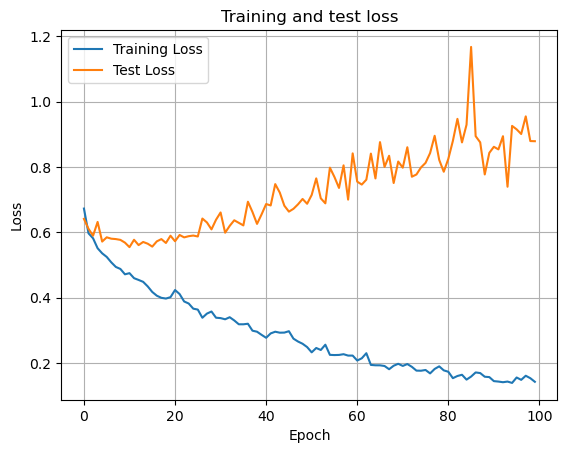

In [690]:
plt.plot(train_loss.values(), label="Training Loss")
plt.plot(test_loss.values(), label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and test loss")
plt.grid(True)

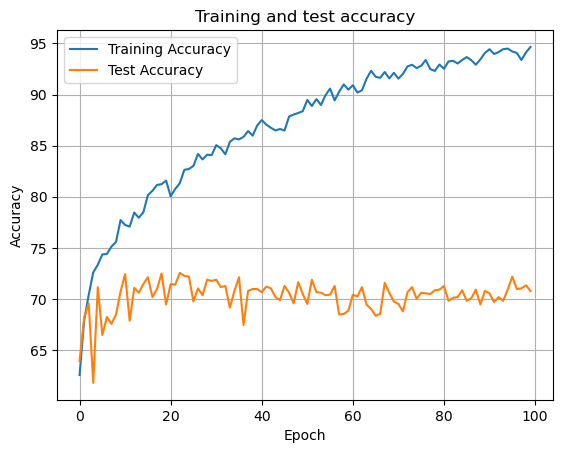

In [691]:
plt.plot(train_accuracy.values(), label="Training Accuracy")
plt.plot(test_accuracy.values(), label="Test Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and test accuracy")
plt.grid(True)

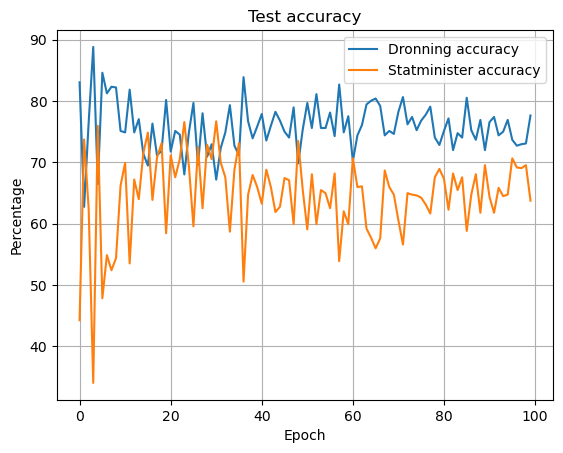

In [692]:
plt.plot(test_labels_dronning.values(), label="Dronning accuracy")
plt.plot(test_labels_statsminister.values(), label="Statminister accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Percentage")
plt.title("Test accuracy")
plt.grid(True)

In [411]:
# %% Save the trained model
# torch.save(net.state_dict(), 'netV11.pt')